In [113]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import product

import sys
sys.path.append('../../')
from funcs.phase_std import get_pdf_moments
from constants.colors import loc_colors, pol_colors

from scipy.stats import linregress

from uavsar_pytools.snow_depth_inversion import depth_from_phase

In [42]:
dss = {fp.stem.replace('_full', ''): {'ds': xr.open_dataset(fp), 'dates': []} for fp in sorted(list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*.nc')))}
for stem, dic in dss.items():
    ds, dates = dic.values()
    for t1, t2, heading in product(ds.time1.values, ds.time2.values, ds.heading.values):
        if (~ds['cor'].sel(time1 = t1, time2 = t2, heading = heading).isnull()).sum() != 0: dss[stem]['dates'].append([int(heading), pd.to_datetime(t1), pd.to_datetime(t2)])

home_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/')
fig_dir = home_dir.joinpath('figures', 'swe_uncertainty')

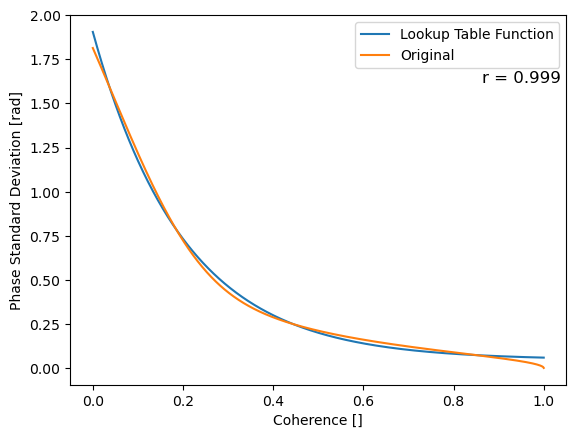

In [64]:
cors = np.linspace(0, 0.9999, 1000)
v = np.vectorize(get_pdf_moments)

def exp_func(x, a, c, d):
    return a*np.exp(-c*x)+d
from scipy.optimize import curve_fit
popt, pcov = curve_fit(exp_func, cors, v(cors, 36), p0=(3, 5, 0.05))
plt.plot(cors, exp_func(cors, *popt), label = 'Lookup Table Function')
plt.plot(cors, v(cors, 36), label = 'Original')
slope, intercept, r_value, p_value, _ = linregress(v(cors, 36), exp_func(cors, *popt))
plt.text(0.99, 0.85,f'r = {r_value:.3f}', transform=plt.gca().transAxes, ha = 'right', va = 'top', size = 12)

plt.legend()
plt.xlabel('Coherence []')
plt.ylabel('Phase Standard Deviation [rad]')


from functools import partial
std_lt = partial(exp_func, a = popt[0], c = popt[1], d = popt[2])

In [156]:
jans = np.array([])
febs = np.array([])
mars = np.array([])
locs = {'co': np.array([]), 'ca': np.array([])}
for stem, dic in dss.items():
    # if stem != 'lowman': continue
    ds, dates = dic.values()
    for heading, t1, t2 in dates:
        dt = np.abs(t2 - t1)
        if dt.days > 8: continue

        cor = ds['cor'].sel(time1 = t1, time2 = t2, heading = heading, pol = 'HH')
        cor = cor.where(ds['inc'].sel(heading = heading) < np.deg2rad(50))
        std_swe = depth_from_phase(std_lt(cor), inc_angle = ds['inc'].sel(heading = heading), density = 200) * 200 / 997
        std_swe = std_swe.values.ravel()

        if t1.month == 1 and t2.month == 1:
            jans = np.concatenate([jans, np.array(std_swe)])
            
        if t1.month ==2 and t2.month == 2:
            febs = np.concatenate([febs, np.array(std_swe)])
            
            if stem in ['dorado', 'peeler', 'rockmt', 'donner', 'sierra']:
                # if stem not in locs.keys(): locs[stem] = np.array(std_swe.values.ravel())
                # else: locs[stem] = np.concatenate([locs[stem], np.array(std_swe.values.ravel())])
                if stem in ['peeler', 'rockmt', 'fraser']: locs['co'] = np.concatenate([locs['co'], std_swe])
                else: locs['ca'] = np.concatenate([locs['ca'], std_swe])
            
        if t1.month == 3 and t2.month == 3:
            mars = np.concatenate([mars, np.array(std_swe)])

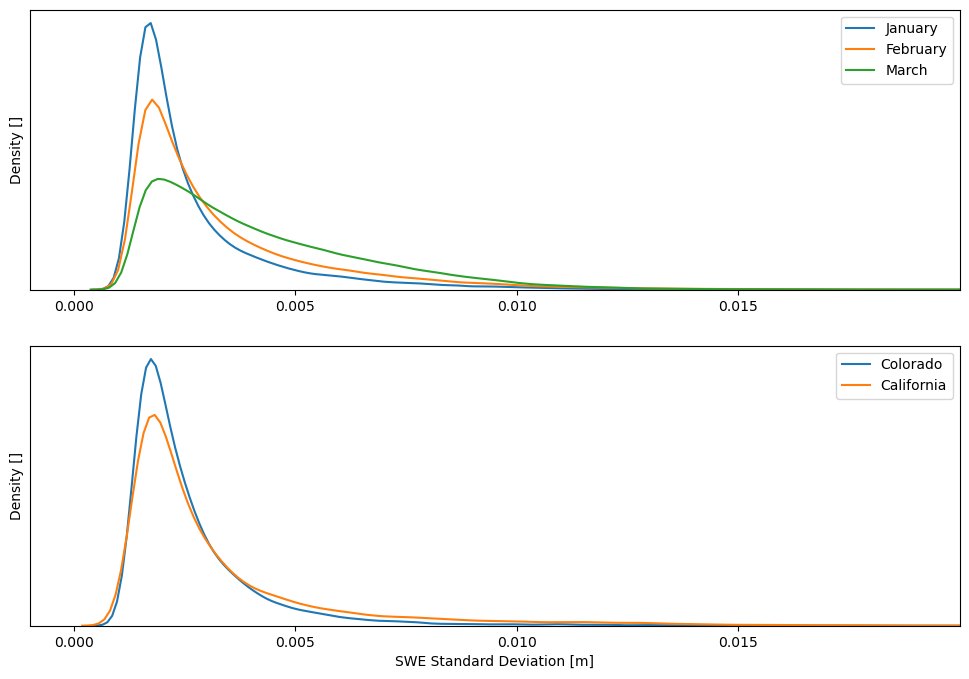

In [166]:
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

# axes[0].hist(jans[~np.isnan(jans)], label = 'January', bins = 300)
# axes[1].hist(mars[~np.isnan(mars)], label = 'March', bins = 300)
for arr, month in zip([jans, febs, mars], ['January', 'February', 'March']):
    sns.kdeplot(arr[~np.isnan(arr)][::100], ax = axes[0], label = month)

for loc, arr in locs.items():
    sns.kdeplot(arr[~np.isnan(arr)][::100], ax = axes[1], label = {'co':'Colorado', 'ca': 'California'}[loc]) 
    # sns.histplot(arr[~np.isnan(arr)][::1000], ax = axes[1], label = loc_colors[loc]['name'], color = loc_colors[loc]['color']. b)
    
for ax in axes:
    # ax.set_xscale('log')
    ax.set_xlim(-0.001, 0.02)
    ax.set_xticks(np.arange(0.00, 0.02, 0.005))
    ax.set_yticks([])
    ax.set_ylabel('Density []')
    ax.set_xlabel('')
    ax.legend()
axes[1].set_xlabel('SWE Standard Deviation [m]')

plt.show()